# W266 Final Project
# Resampling
# October 9, 2022
# John Clark, Shrinivas Joshi, Courtney Kennedy


# There are several different resampling strategies to try

####First, we want to look at using the four letter types as well as the categorical variables, and create new distributions by under and over sampling based on both ways of organizing the data.

####Second, we want to try over/under sampling to get to different distributions.  These will include a uniform distribution across all categories and then a distribution that matches the natural distribution found in the general population.

In [1]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Oct 23 00:00:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [96]:
# imports
import sys
import csv


import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.utils import resample
from sklearn.utils import shuffle


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Configuration Flags

useGCloudForStorage = True



In [7]:

# Global State Flags
uploadedGCloudCredentials = False
mountedGoogleDrive = False
configuredGCloud = False


# Global Variables
gdrive_path = '/content/drive/MyDrive/content/drive/'

gcloud_bucket = None
gcloud_bucket_name = ""

In [8]:
# To work from a google drive use this:
from google.colab import drive

def mount_google_drive():
    global userGCloudForStorage
    global mountedGoogleDrive

    if useGCloudForStorage == False:
        if mountedGoogleDrive == False:
            drive.mount('/content/drive')
            mountedGoogleDrive = True



In [9]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    global useGCloudForStorage
    global uploadedGCloudCredentials

    if useGCloudForStorage:
        if uploadedGCloudCredentials == False:

            uploaded = files.upload()
            uploadedGCloudCredentials = True


def config_GCloud():
    global configuredGCloud
    global gcloud_bucket
    global gcloud_bucket_name

    if configuredGCloud:
        return gcloud_bucket, gcloud_bucket_name

    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

    configuredGCloud = True

    return gcloud_bucket, gcloud_bucket_name


In [10]:
# Read source data files in and create dataframes

def read_sources_from_Drive():
    global useGCloudForStorage

    if useGCloudForStorage == True:  
        return

    mount_google_drive()

    # test file is a 1000 row file to use in developing data cleaning routines before tackling the real files
    # test_posts_df = pd.read_csv( '/content/drive/MyDrive/content/drive/test_posts.csv')

    # Two forms of Posts files- both a full dataframe and an iterator
    posts_full_df = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo-9-25-22-posts.csv')
    posts_iterator = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo-9-25-22-posts.csv', chunksize = 10000)

    header_df = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo.csv')

    return header_df, posts_full_df, posts_iterator


def read_sources_from_GCloud():
    global useGCloudForStorage

    if useGCloudForStorage == False:
        return

    upload_gcloud_credentials()
    bucket, bucket_name = config_GCloud()

    #Grab blob header file and download as string
    users = bucket.blob('typology_xenforo-9-25-22.csv')
    string_data_users = users.download_as_string()
    print( string_data_users )

    #Convert to pandas
    header_df = pd.read_csv(io.BytesIO(string_data_users), encoding='utf-8', sep=',', engine='python')

    #Grab blob posts file and download as string
    posts = bucket.blob('typology_xenforo-9-25-22-posts.csv')
    string_data_posts = posts.download_as_string()
    print( string_data_posts)

    #Convert to pandas
    posts_full_df = pd.read_csv(io.BytesIO(string_data_posts), encoding='utf-8', sep=',', engine='python')

    posts_iterator = pd.read_csv(io.BytesIO(string_data_posts), encoding='utf-8', sep=',', chunksize = 10000)

    return header_df, posts_full_df, posts_iterator



Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6.json
<Bucket: 266csffile>
dev_mbti_data.csv
dev_mbti_labels.csv
test_mbti_data.csv
test_mbti_labels.csv
train_mbti_data.csv
train_mbti_labels.csv
typology_users_clean.csv
typology_xenforo-9-25-22-posts.csv
typology_xenforo-9-25-22.csv
typology_xenforo-9-25-22_clean.parquet
b'"Username","Age","Posts","MBTI Type","Enneagram","Instinctual Variant","Gender","Occupation"\n"\x01\x01\x01\x01 Adi \x01\x01\x01\x01",45,0,NULL,NULL,NULL,NULL,NULL\n"",49,0,NULL,NULL,NULL,NULL,NULL\n"!motivational",40,0,NULL,NULL,NULL,NULL,NULL\n"!sfj",74,0,"ISFJ",NULL,NULL,NULL,NULL\n"""?""",NULL,1167,"TiSe",NULL,NULL,NULL,NULL\n"""jake""",27,0,"ESTJ",NULL,NULL,NULL,NULL\n"#soochelve",34,0,"#soo","5 or",NULL,NULL,NULL\n"#Uttetriva",62,0,"#Utt","5 or",NULL,NULL,NULL\n"$$fullbodymulletzz$$",120,0,NULL,NULL,NULL,"not_specified",NULL\n"$andie33",55,0,NULL,NULL,NULL,NULL,NULL\n"&chet",30,0,"ENTP",7,NULL,NULL,NULL\n"\'Veracity\'",36,0,"

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
# write parquet files

def write_parquet_gdrive( df, filename):
    global gdrive_path

    full_path_to_file = gdrive_path + filename

    print( full_path_to_file)
    df.to_parquet(full_path_to_file)


def write_parquet_google_cloud( df, filename):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob.upload_from_string(df.to_parquet(), 'application/octet-stream')

def write_parquet_file( dataframe, filename):

    global useGCloudForStorage

    if useGCloudForStorage:
        write_parquet_google_cloud( dataframe, filename )
    else:
        write_parquet_gdrive( dataframe, filename )



In [13]:
upload_gcloud_credentials()
bucket, bucket_name = config_GCloud()



In [14]:
# read in the already cleaned posts data

posts_filename = 'typology_xenforo-9-25-22_clean.parquet'

print( posts_filename)

# read back and look for corruption
bucket, bucket_name = config_GCloud()

read_back = bucket.blob(posts_filename)
string_read_back = read_back.download_as_string()
posts_df = pd.read_parquet(io.BytesIO(string_read_back))




typology_xenforo-9-25-22_clean.parquet


In [18]:
# read in the already cleaned header(user) data

header_filename = 'typology_users_clean.csv'

bucket, bucket_name = config_GCloud()

header_blob = bucket.blob( header_filename )
header_string = header_blob.download_as_string()
   
users_df = pd.read_csv(io.BytesIO(header_string), engine='python')





In [39]:
# read in the already cleaned, merged data

merged_filename = 'typology_merged.parquet'

print( merged_filename)

# read back and look for corruption
bucket, bucket_name = config_GCloud()

read_back = bucket.blob(merged_filename)
string_read_back = read_back.download_as_string()
merged_df = pd.read_parquet(io.BytesIO(string_read_back))




typology_merged.parquet


In [40]:
# take stock of what we have


# merged statistics

print( "merged shape:", merged_df.shape )
print( "merged columns:", merged_df.columns )
print( "merged index:", merged_df.index )

merged_df = merged_df.drop(['Unnamed: 0'], axis=1)

print( "merged shape:", merged_df.shape )
print( "merged columns:", merged_df.columns )








merged shape: (1611083, 17)
merged columns: Index(['Unnamed: 0', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
merged index: Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1611073, 1611074, 1611075, 1611076, 1611077, 1611078, 1611079,
            1611080, 1611081, 1611082],
           dtype='int64', length=1611083)
merged shape: (1611083, 16)
merged columns: Index(['Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')


##General Population Distribution, according to the Myers Briggs Website

From https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm

That data is from 2002.  
Here's another source that largely agrees:
https://personalitymax.com/personality-types/population-gender/


[link text](https://drive.google.com/file/d/1JuEw-cDa38wcex_igwtohygpv0q52vT3/view?usp=sharing)



In [86]:
# Valid MBTI Types

valid_MBTI = ['ISTJ', 
              'INTJ', 
              'ESTJ', 
              'ENTJ', 
              'ENTP', 
              'INTP', 
              'ISTP', 
              'ESTP', 
              'ISFJ', 
              'INFJ', 
              'ESFJ', 
              'ENFJ', 
              'ENFP', 
              'INFP', 
              'ISFP', 
              'ESFP']

valid_subtypes = [ 'Introverted',
                   'Extroverted',
                   'Sensing',
                   'Intuitive',
                   'Thinking',
                   'Feeling',
                   'Judging',
                   'Perceiving' ]


In [97]:
def get_MBTI_distribution( input_df ):
    total_posts = input_df.shape[0]

    mbti_type_counts = input_df['MBTI Type'].value_counts()
    print( mbti_type_counts)

    mbti_data_pct = [ mbti_type_counts[type]/total_posts for type in valid_MBTI ]
    print( mbti_data_pct)

    i_type_counts = input_df['is_I'].value_counts()
    s_type_counts = input_df['is_S'].value_counts()
    t_type_counts = input_df['is_T'].value_counts()
    j_type_counts = input_df['is_J'].value_counts()

    subtypes_data_counts = [i_type_counts[True],
                            i_type_counts[False],
                            s_type_counts[True],
                            s_type_counts[False],
                            t_type_counts[True],
                            t_type_counts[False],
                            j_type_counts[True],
                            j_type_counts[False]
                            ]
    print( subtypes_data_counts)
    subtypes_data_pct = [ i/total_posts for i in subtypes_data_counts ]
    print( subtypes_data_pct)

    return mbti_type_counts, mbti_data_pct, subtypes_data_counts, subtypes_data_pct


In [98]:
# get distribution of MBTI types and of categorical types in our data

mbti_type_counts, mbti_data_pct, subtypes_data_counts, subtypes_data_pct = get_MBTI_distribution( merged_df )


INTJ    228701
INFP    216037
INTP    214658
ENFP    183607
INFJ    162980
ENTP    148135
ENTJ     71974
ISTP     69981
ISFP     64670
ENFJ     47045
ESFJ     41885
ESTJ     36633
ESFP     33965
ESTP     33643
ISTJ     33379
ISFJ     23790
Name: MBTI Type, dtype: int64
[0.020718361499686856, 0.14195482169447507, 0.022738120878936716, 0.04467429673083261, 0.09194746639372398, 0.13323832477904615, 0.04343724066357847, 0.020882226427812844, 0.014766464545898628, 0.10116176509838413, 0.02599803982786734, 0.029200854332148002, 0.11396495400919754, 0.1340942707483103, 0.04014070038601363, 0.021082091984087722]
[1014196, 596887, 337946, 1273137, 837104, 773979, 646387, 964696]
[0.6295119494153932, 0.37048805058460677, 0.2097632462138822, 0.7902367537861178, 0.5195908590680927, 0.4804091409319073, 0.4012127246082294, 0.5987872753917707]


In [99]:
# General Population Distribution

mbti_est_gen_pop_pct = [.116,  # ISTJ
                        .021,  # INTJ
                        .087,  # ESTJ
                        .018,  # ENTJ
                        .032,  # ENTP
                        .033,  # INTP
                        .054,  # ISTP
                        .043,  # ESTP
                        .138,  # ISFJ
                        .015,  # INFJ
                        .120,  # ESFJ
                        .025,  # ENFJ
                        .081,  # ENFP
                        .044,  # INFP
                        .088,  # ISFP
                        .085 ] # ESFP
                              
subtypes_est_gen_pop_pct = [ .507,  # Introverted
                             .493,  # Extroverted
                             .733,  # Sensing
                             .267,  # Intuitive
                             .402,  # Thinking
                             .598,  # Feeling
                             .541,  # Judging
                             .459]  # Perceiving

mbti_uniform_pct = [1/len(valid_MBTI) for i in range( 0, len(valid_MBTI))]
subtypes_uniform_pct = [1/len(valid_subtypes) for i in range( 0, len(valid_subtypes))]



In [100]:
mbti_dist = list( zip( valid_MBTI, mbti_data_pct, mbti_est_gen_pop_pct, mbti_uniform_pct))

mbti_dist_df = pd.DataFrame( mbti_dist)
mbti_dist_df.columns = ['MBTI Type', 'Data', 'Population', 'Uniform']
print( mbti_dist_df )

subtypes_dist = list( zip(valid_subtypes, subtypes_data_pct, subtypes_est_gen_pop_pct,  subtypes_uniform_pct))
subtypes_dist_df = pd.DataFrame( subtypes_dist)
subtypes_dist_df.columns = ['MBTI Subtype', 'Data', 'Population', 'Uniform']
print( subtypes_dist_df )



   MBTI Type      Data  Population  Uniform
0       ISTJ  0.020718       0.116   0.0625
1       INTJ  0.141955       0.021   0.0625
2       ESTJ  0.022738       0.087   0.0625
3       ENTJ  0.044674       0.018   0.0625
4       ENTP  0.091947       0.032   0.0625
5       INTP  0.133238       0.033   0.0625
6       ISTP  0.043437       0.054   0.0625
7       ESTP  0.020882       0.043   0.0625
8       ISFJ  0.014766       0.138   0.0625
9       INFJ  0.101162       0.015   0.0625
10      ESFJ  0.025998       0.120   0.0625
11      ENFJ  0.029201       0.025   0.0625
12      ENFP  0.113965       0.081   0.0625
13      INFP  0.134094       0.044   0.0625
14      ISFP  0.040141       0.088   0.0625
15      ESFP  0.021082       0.085   0.0625
  MBTI Subtype      Data  Population  Uniform
0  Introverted  0.629512       0.507    0.125
1  Extroverted  0.370488       0.493    0.125
2      Sensing  0.209763       0.733    0.125
3    Intuitive  0.790237       0.267    0.125
4     Thinking  0.5195

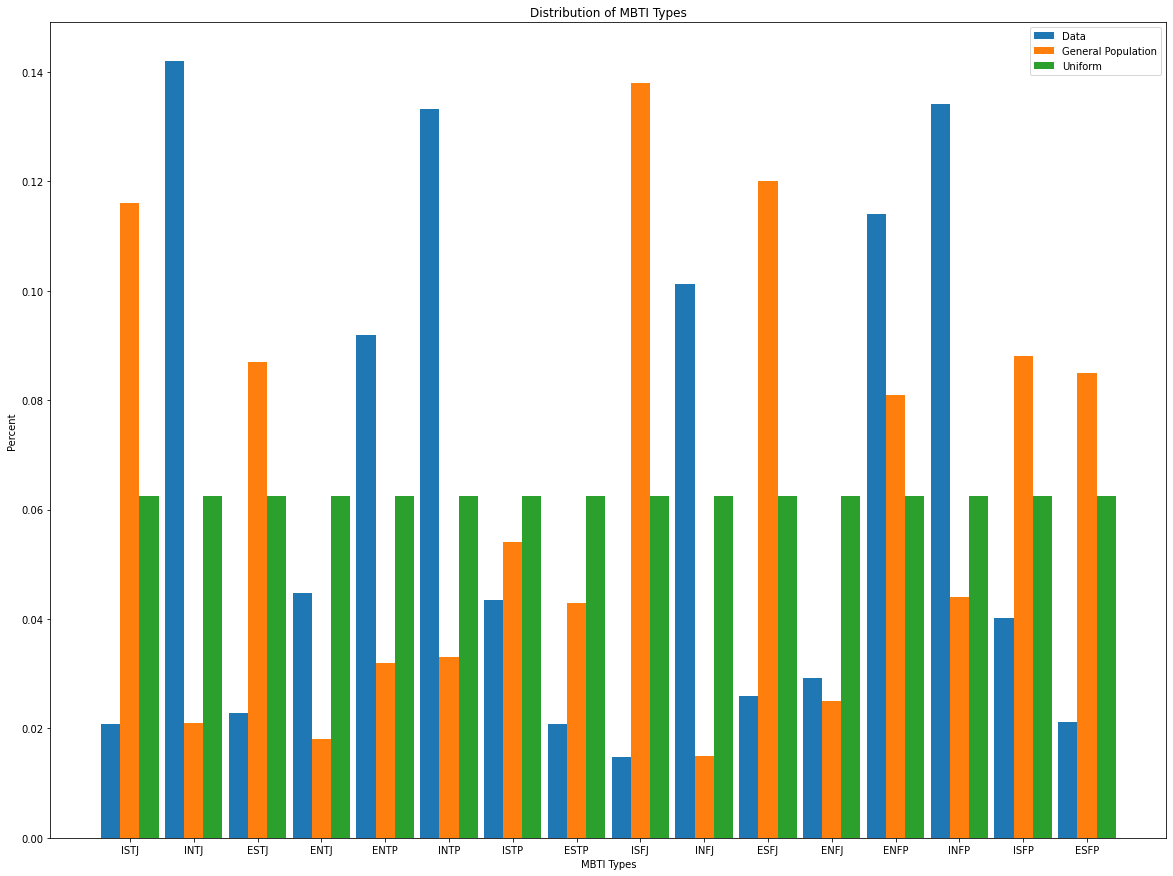

In [101]:
# plot MBTI distributions for data, general population, uniform  

X_axis = np.arange(len(valid_MBTI))  
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)


plt.bar(X_axis - .3, mbti_data_pct, 0.3, label = 'Data')
plt.bar(X_axis + 0, mbti_est_gen_pop_pct, 0.3, label = 'General Population')
plt.bar(X_axis + .3, mbti_uniform_pct, 0.3, label = 'Uniform')
  
plt.xticks(X_axis, valid_MBTI)
plt.xlabel("MBTI Types")
plt.ylabel("Percent")
plt.title("Distribution of MBTI Types")
plt.legend()


plt.show()

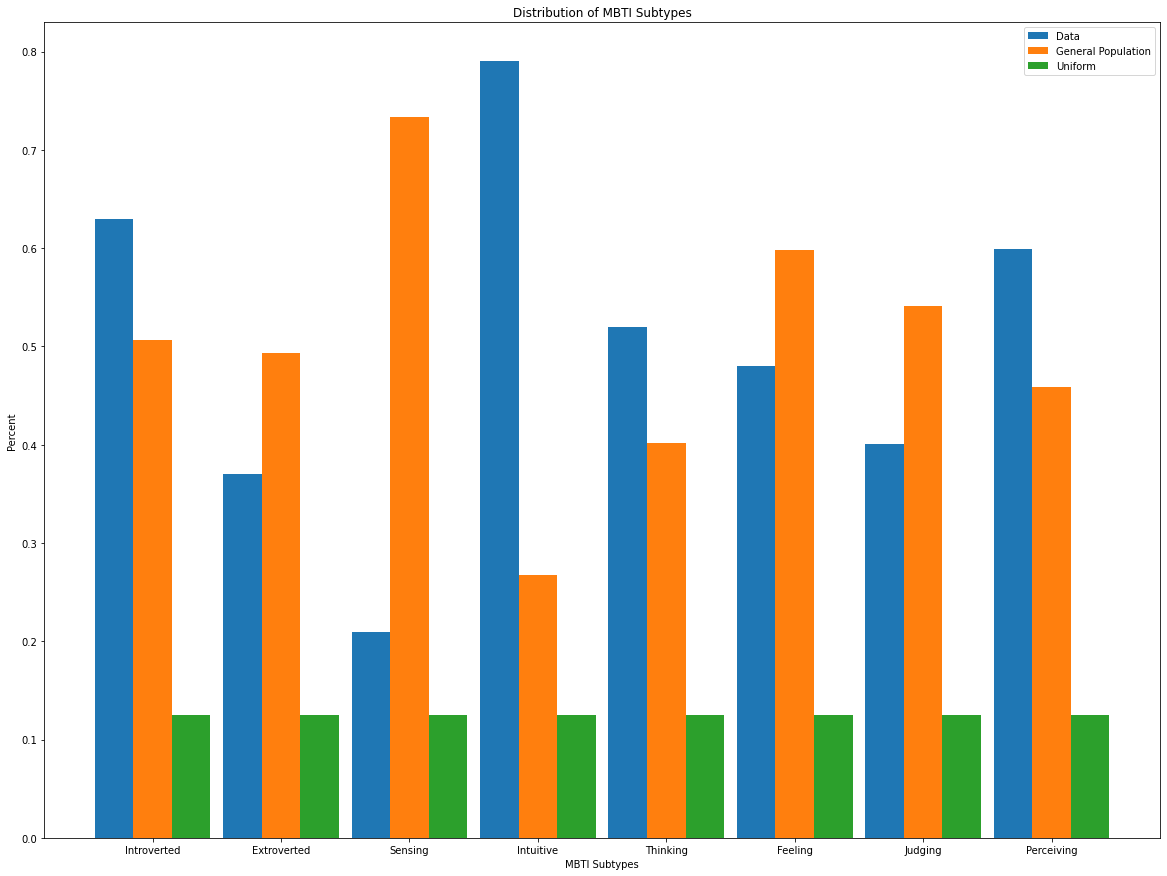

In [102]:
# plot MBTI subtypes distributions for data, general population, uniform  

X_axis = np.arange(len(valid_subtypes))  
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)


plt.bar(X_axis - .3, subtypes_data_pct, 0.3, label = 'Data')
plt.bar(X_axis + 0, subtypes_est_gen_pop_pct, 0.3, label = 'General Population')
plt.bar(X_axis + .3, subtypes_uniform_pct, 0.3, label = 'Uniform')
  
plt.xticks(X_axis, valid_subtypes)
plt.xlabel("MBTI Subtypes")
plt.ylabel("Percent")
plt.title("Distribution of MBTI Subtypes")
plt.legend()


plt.show()

In [103]:
def read_csv_from_gcloud( filename ):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob_string = blob.download_as_string()
    
    read_df = pd.read_csv(io.BytesIO(blob_string), engine='python')
    return read_df




In [108]:
# read the Training, Test and Dev splits in from files

# Training
train_df = read_csv_from_gcloud( 'train_mbti_data.csv')
# train_Y_df = read_csv_from_gcloud( 'train_mbti_labels.csv')

# # put the data back together for the resampling process
# train_df  = pd.concat([train_X_df, train_Y_df], axis=1)
print( "train_df shape:", train_df.shape )
print( "train_df columns:", train_df.columns )

# Test
test_df = read_csv_from_gcloud( 'test_mbti_data.csv')
# test_Y_df = read_csv_from_gcloud( 'test_mbti_labels.csv')

# # put the data back together for analysis
# test_df  = pd.concat([test_X_df, test_Y_df], axis=1)
print( "test_df shape:", test_df.shape )
print( "test_df columns:", test_df.columns )


# Dev
dev_df = read_csv_from_gcloud( 'dev_mbti_data.csv')
# dev_Y_df = read_csv_from_gcloud( 'dev_mbti_labels.csv')

# # put the data back together for analysis
# dev_df  = pd.concat([dev_X_df, dev_Y_df], axis=1)
print( "dev_df shape:", dev_df.shape )
print( "dev_df columns:", dev_df.columns )




train_df shape: (1200000, 18)
train_df columns: Index(['Unnamed: 0', 'Unnamed: 0.1', 'Username', 'Age', 'Posts', 'MBTI Type',
       'Enneagram', 'Instinctual Variant', 'Gender', 'Occupation', 'is_I',
       'is_S', 'is_T', 'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
test_df shape: (200000, 18)
test_df columns: Index(['Unnamed: 0', 'Unnamed: 0.1', 'Username', 'Age', 'Posts', 'MBTI Type',
       'Enneagram', 'Instinctual Variant', 'Gender', 'Occupation', 'is_I',
       'is_S', 'is_T', 'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
dev_df shape: (200000, 18)
dev_df columns: Index(['Unnamed: 0', 'Unnamed: 0.1', 'Username', 'Age', 'Posts', 'MBTI Type',
       'Enneagram', 'Instinctual Variant', 'Gender', 'Occupation', 'is_I',
       'is_S', 'is_T', 'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')


In [109]:
# Now do a sanity check of the distribution in the Training, Test and Dev splits of the data

train_type_counts, train_data_pct, train_sub_data_counts, train_sub_data_pct = get_MBTI_distribution( train_df )
test_type_counts, test_data_pct, test_sub_data_counts, test_sub_data_pct = get_MBTI_distribution( test_df )
dev_type_counts, dev_data_pct, dev_sub_data_counts, dev_sub_data_pct = get_MBTI_distribution( dev_df )


INTJ    170285
INFP    160567
INTP    160019
ENFP    137052
INFJ    121476
ENTP    110469
ENTJ     53593
ISTP     52033
ISFP     48114
ENFJ     35051
ESFJ     31215
ESTJ     27344
ESFP     25341
ESTP     24998
ISTJ     24761
ISFJ     17682
Name: MBTI Type, dtype: int64
[0.020634166666666665, 0.14190416666666666, 0.022786666666666667, 0.04466083333333333, 0.0920575, 0.13334916666666666, 0.043360833333333335, 0.020831666666666665, 0.014735, 0.10123, 0.0260125, 0.029209166666666668, 0.11421, 0.13380583333333335, 0.040095, 0.0211175]
[754937, 445063, 251488, 948512, 623502, 576498, 481407, 718593]
[0.6291141666666666, 0.37088583333333336, 0.20957333333333333, 0.7904266666666667, 0.519585, 0.480415, 0.4011725, 0.5988275]
INTJ    28651
INFP    27027
INTP    26519
ENFP    22579
INFJ    20104
ENTP    18207
ENTJ     8835
ISTP     8813
ISFP     8062
ENFJ     5819
ESFJ     5318
ESTJ     4511
ESTP     4212
ESFP     4204
ISTJ     4187
ISFJ     2952
Name: MBTI Type, dtype: int64
[0.020935, 0.143255,

In [110]:
# plot MBTI distributions for data, general population, uniform  

def plot_MBTI_distribution( title, input_MBTI_pct ):

    X_axis = np.arange(len(valid_MBTI))  
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)


    plt.bar(X_axis - .3, input_MBTI_pct, 0.3, label = 'Data')
    plt.bar(X_axis + 0, mbti_est_gen_pop_pct, 0.3, label = 'General Population')
    plt.bar(X_axis + .3, mbti_uniform_pct, 0.3, label = 'Uniform')
    
    plt.xticks(X_axis, valid_MBTI)
    plt.xlabel("MBTI Types")
    plt.ylabel("Percent")
    plt.title(title)
    plt.legend()


    plt.show()

def plot_MBTI_subtypes_distribution( title, input_subtypes_dist ):

    X_axis = np.arange(len(valid_subtypes))  
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)


    plt.bar(X_axis - .3, input_subtypes_dist, 0.3, label = 'Data')
    plt.bar(X_axis + 0, subtypes_est_gen_pop_pct, 0.3, label = 'General Population')
    plt.bar(X_axis + .3, subtypes_uniform_pct, 0.3, label = 'Uniform')
    
    plt.xticks(X_axis, valid_subtypes)
    plt.xlabel("MBTI Subtypes")
    plt.ylabel("Percent")
    plt.title(title)
    plt.legend()


    plt.show()

In [ ]:
# Let's take a look - we should see the same distribution across the train, test and dev sets

plot_MBTI_distribution( 'Distribution of MBTI Types in Train Set', train_data_pct )
plot_MBTI_distribution( 'Distribution of MBTI Types in Test Set', test_data_pct )
plot_MBTI_distribution( 'Distribution of MBTI Types in Dev Set', dev_data_pct )

plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Train Set', train_sub_data_pct )
plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Test Set', test_sub_data_pct )
plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Dev Set', dev_sub_data_pct )

In [ ]:
# Now, resampling

# First, work on uniform distributions which are simpler
# Strategy 1:  Undersampling to uniform
# Strategy 2:  Oversampling to uniform

# Second, work on general population distribution
# Strategy 3:  Undersampling to general population
# Strategy 4:  Oversampling to general population